# Vanilla AutoEncoder Example with CIFAR10

![alt text](ae.png "Title")

# Imports

In [1]:
import torch, torchvision, time
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
torch.manual_seed(547)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Configurations

In [2]:
EPOCHS = 15
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 0
LATENT_DIM = 128

# Dataloader and Pre-processing

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train = datasets.CIFAR10(root="./data", train=True,  download=True, transform=transform)
test  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test,  batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Data sample visualization

In [4]:
image, class_label = train[107]
input_shape = image.size()
print("input shape:", image.shape)

input shape: torch.Size([3, 32, 32])


In [5]:
# the default range of the torchvision image data is (0, 1)
image.min(), image.max()

(tensor(0.), tensor(0.9490))

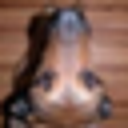

Class label 5


In [6]:
display(transforms.functional.to_pil_image(image).resize((128,128)))
print("Class label", class_label)

# Model

### Encoder

In [7]:
class encoder(nn.Module):
    def __init__(self, in_channel=3, channels=[16, 32]):
        super(encoder, self).__init__()
        channels = [in_channel] + channels
        self.downsample = nn.ModuleList()
        for i in range(1, len(channels)):
            self.downsample.extend([
                nn.Conv2d(in_channels=channels[i-1], out_channels=channels[i], kernel_size=3, stride=2, padding=1),
                nn.Conv2d(in_channels=channels[i],   out_channels=channels[i], kernel_size=3, stride=1, padding=1),
            ])
            
        self.relu = nn.ReLU()
        
    def forward(self, x, verbose=0):
        if verbose:
            print(f"Encoder input shape: {x.shape}")
        
        for i, donwsample_layer in enumerate(self.downsample):
            x = donwsample_layer(x)
            x = self.relu(x)
            
            if verbose:
                print(f"Encoder layer_{i} output shape: {x.shape}")
        
        return x
        

### Decoder

In [8]:
class decoder(nn.Module):
    def __init__(self, out_channel=3, channels=[16, 32]):
        super(decoder, self).__init__()
        channels = [out_channel] + channels
        self.upsample = nn.ModuleList()
        for i in range(len(channels)-2, -1, -1):
             self.upsample.extend([
                 nn.ConvTranspose2d(in_channels=channels[i+1], out_channels=channels[i], kernel_size=3, stride=2, padding=1, output_padding=1),
                 nn.ConvTranspose2d(in_channels=channels[i],   out_channels=channels[i], kernel_size=3, stride=1, padding=1, output_padding=0),
             ])
        
        self.relu = nn.ReLU()
        
    def forward(self, x, verbose=0):
        if verbose:
            print(f"Decoder input shape: {x.shape}")
        for i, upsample_layer in enumerate(self.upsample):
            x = upsample_layer(x)
            x = self.relu(x)
            
            if verbose:
                print(f"Decoder layer_{i} output shape: {x.shape}")
            
        return x

### AutoEncoder

In [9]:
class autoencoder(nn.Module):
    def __init__(self, inp_shape, latent_dim=128, channels=[16, 32, 64]):
        super(autoencoder, self).__init__()
        self.downsample_size = (channels[-1],
                                inp_shape[1]//(2 ** len(channels)), 
                                inp_shape[2]//(2 ** len(channels)))
        
        self.encoder     = encoder(in_channel=inp_shape[0], channels=channels)
        self.to_latent   = nn.Linear(self.downsample_size[0] * self.downsample_size[1] * self.downsample_size[2], latent_dim)
        self.from_latent = nn.Linear(latent_dim, self.downsample_size[0] * self.downsample_size[1] * self.downsample_size[2])
        self.decoder     = decoder(out_channel=inp_shape[0], channels=channels)
        self.relu        = nn.ReLU()
        self.sigmoid     = nn.Sigmoid()
        
        
    def forward(self, x, verbose=0):
        latent = self.encode(x, verbose=verbose)
        rec = self.decode(latent, verbose=verbose)
        
        return rec
    
    def encode(self, x, verbose=0):
        x = self.encoder(x, verbose=verbose)
        assert x.shape[1:] == self.downsample_size, "Encoder output shape does not match downsample_size" 
        
        # flatten
        x = x.view(x.shape[0], -1)
        
        # project to latent dimension
        latent = self.to_latent(x)
        latent = self.relu(latent)
        return latent
    
    def decode(self, latent, verbose=0):
        # reshape to downsample size
        latent = self.from_latent(latent)
        latent = latent.reshape(latent.shape[0], *self.downsample_size)
        rec = self.decoder(latent, verbose=verbose)
        return rec

# Define model

In [10]:
model = autoencoder(input_shape, latent_dim=LATENT_DIM, channels=[16, 32, 64]).to(device)

for param in layer.parameters():
    param.requries_grad = False

# Test model on random data

In [11]:
input_shape

torch.Size([3, 32, 32])

In [12]:
sample_input = torch.rand((4, 3, 32, 32), dtype=torch.float32).to(device)
reconsturction = model(sample_input, verbose=1)

Encoder input shape: torch.Size([4, 3, 32, 32])
Encoder layer_0 output shape: torch.Size([4, 16, 16, 16])
Encoder layer_1 output shape: torch.Size([4, 16, 16, 16])
Encoder layer_2 output shape: torch.Size([4, 32, 8, 8])
Encoder layer_3 output shape: torch.Size([4, 32, 8, 8])
Encoder layer_4 output shape: torch.Size([4, 64, 4, 4])
Encoder layer_5 output shape: torch.Size([4, 64, 4, 4])
Decoder input shape: torch.Size([4, 64, 4, 4])
Decoder layer_0 output shape: torch.Size([4, 32, 8, 8])
Decoder layer_1 output shape: torch.Size([4, 32, 8, 8])
Decoder layer_2 output shape: torch.Size([4, 16, 16, 16])
Decoder layer_3 output shape: torch.Size([4, 16, 16, 16])
Decoder layer_4 output shape: torch.Size([4, 3, 32, 32])
Decoder layer_5 output shape: torch.Size([4, 3, 32, 32])


In [13]:
#summary(model, input_size=(3, 32, 32), device='cuda')

# Second Alternative Model Structure

In [14]:
class encoder2(nn.Module):
    def __init__(self, in_channel=3):
        super(encoder2, self).__init__()
        self.down_sample1 = nn.Conv2d(in_channels=3,  out_channels=16, kernel_size=3, stride=2, padding=1)
        self.down_sample2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.down_sample3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.down_sample4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.down_sample5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.down_sample6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.down_sample1(x)
        x = self.relu(x)
        x = self.down_sample2(x)
        x = self.relu(x)
        x = self.down_sample3(x)
        x = self.relu(x)
        x = self.down_sample4(x)
        x = self.relu(x)
        x = self.down_sample5(x)
        x = self.relu(x)
        x = self.down_sample6(x)
        x = self.relu(x)
        return x

class decoder2(nn.Module):
    def __init__(self, out_channel=3):
        super(decoder2, self).__init__()
        self.upsample1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample2 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, output_padding=0)
        self.upsample3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample4 = nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, output_padding=0)
        self.upsample5 = nn.ConvTranspose2d(in_channels=16, out_channels=3,  kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample6 = nn.ConvTranspose2d(in_channels=3,  out_channels=3,  kernel_size=3, stride=1, padding=1, output_padding=0)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.upsample1(x)
        x = self.relu(x)
        x = self.upsample2(x)
        x = self.relu(x)
        x = self.upsample3(x)
        x = self.relu(x)
        x = self.upsample4(x)
        x = self.relu(x)
        x = self.upsample5(x)
        x = self.relu(x)
        x = self.upsample6(x)
        x = self.relu(x)
            
        return x
    
class autoencoder2(nn.Module):
    def __init__(self, inp_shape, latent_dim=128, channels=[16, 32, 64]):
        super(autoencoder2, self).__init__()
        self.downsample_size = (channels[-1],
                                inp_shape[1]//(2 ** len(channels)), 
                                inp_shape[2]//(2 ** len(channels)))
        
        self.encoder     = encoder2(in_channel=inp_shape[0])
        self.to_latent   = nn.Linear(self.downsample_size[0] * self.downsample_size[1] * self.downsample_size[2], latent_dim)
        self.from_latent = nn.Linear(latent_dim, self.downsample_size[0] * self.downsample_size[1] * self.downsample_size[2])
        self.decoder     = decoder2(out_channel=inp_shape[0])
        self.relu        = nn.ReLU()
        self.sigmoid     = nn.Sigmoid()
        
        
    def forward(self, x):
        latent = self.encode(x)
        rec    = self.decode(latent)
        
        return rec
    
    def encode(self, x):
        x = self.encoder(x)
        assert x.shape[1:] == self.downsample_size, "Encoder output shape does not match downsample_size" 
        
        # flatten
        x = x.view(x.shape[0], -1)
        
        # project to latent dimension
        latent = self.to_latent(x)
        latent = self.relu(latent)
        return latent
    
    def decode(self, latent):
        # reshape to downsample size
        latent = self.from_latent(latent)
        latent = latent.reshape(latent.shape[0], *self.downsample_size)
        rec    = self.decoder(latent)
        return rec

In [15]:
model2 = autoencoder2(input_shape, latent_dim=LATENT_DIM, channels=[16, 32, 64]).to(device)
#print(model2)

# Loss and Optimizer

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,12,15], gamma=0.1)

# Visualize latent space before training

/home/emrecan/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/emrecan/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.000s...
[t-SNE] Computed neighbors for 6400 samples in 0.598s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 0.000851
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.571091
[t-SNE] KL divergence after 1000 iterations: 2.704961


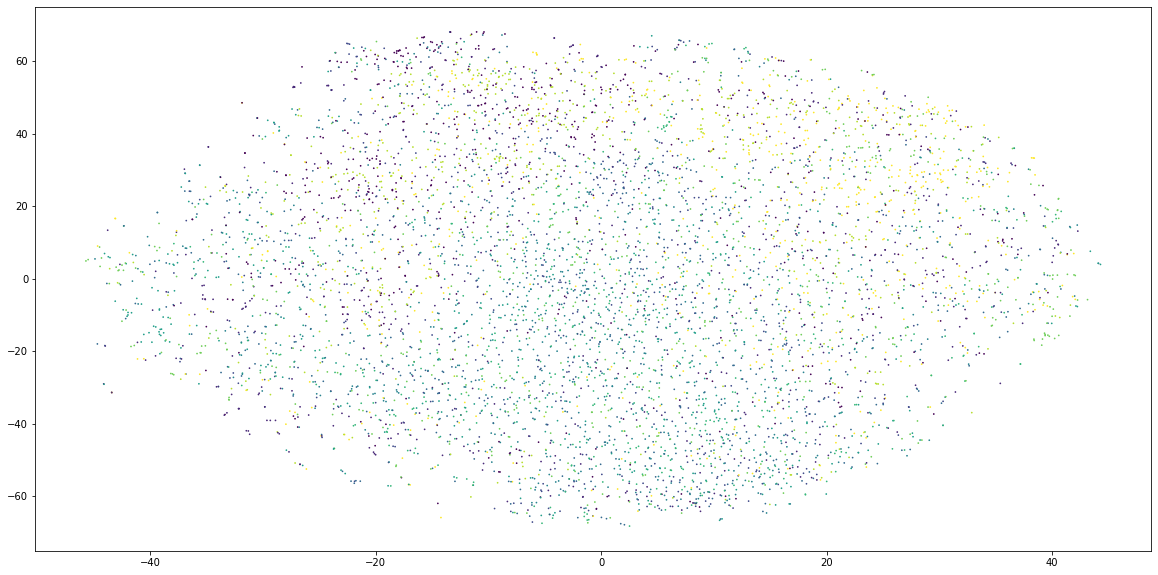

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import itertools
%matplotlib inline

latents = []
classes = [] 
with torch.no_grad():
    for images, cls_labels in itertools.islice(train_loader, 50):
        images = images.to(device)
        latents.extend(model.encode(images).cpu().numpy())
        classes.extend(cls_labels.numpy())


# project to 2d for visualization
embed = TSNE(n_components = 2, verbose=True)
Y = embed.fit_transform(latents)

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(Y[:,0], Y[:,1], c = classes, s = 0.5)

# Training

In [18]:
from tqdm import tqdm
outputs = []
losses = []
for epoch in tqdm(range(EPOCHS)):
    running_train_loss = 0
    start_time = time.time()
    for image, cls_label in train_loader:
        image, _ = image.to(device), cls_label.to(device)
        
        output = model(image)
        loss = criterion(output, image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    outputs.append((epoch+1, image[0], output[0]))
    loss = running_train_loss / len(train_loader)
    losses.append(loss)
    end_time = time.time()
    #scheduler.step()
    print(f"Epoch [{epoch+1}/{EPOCHS}], loss:{loss:.4f} in {(end_time-start_time):.2f}s")

  7%|▋         | 1/15 [00:05<01:22,  5.90s/it]

Epoch [1/15], loss:0.0558 in 5.90s


 13%|█▎        | 2/15 [00:11<01:16,  5.88s/it]

Epoch [2/15], loss:0.0210 in 5.86s


 20%|██        | 3/15 [00:17<01:10,  5.88s/it]

Epoch [3/15], loss:0.0181 in 5.87s


 27%|██▋       | 4/15 [00:23<01:04,  5.86s/it]

Epoch [4/15], loss:0.0149 in 5.84s


 33%|███▎      | 5/15 [00:29<00:58,  5.85s/it]

Epoch [5/15], loss:0.0135 in 5.84s


 40%|████      | 6/15 [00:35<00:52,  5.85s/it]

Epoch [6/15], loss:0.0127 in 5.84s


 47%|████▋     | 7/15 [00:41<00:46,  5.85s/it]

Epoch [7/15], loss:0.0124 in 5.86s


 53%|█████▎    | 8/15 [00:46<00:40,  5.85s/it]

Epoch [8/15], loss:0.0115 in 5.85s


 60%|██████    | 9/15 [00:52<00:35,  5.84s/it]

Epoch [9/15], loss:0.0112 in 5.81s


 67%|██████▋   | 10/15 [00:58<00:29,  5.80s/it]

Epoch [10/15], loss:0.0107 in 5.72s


 73%|███████▎  | 11/15 [01:04<00:23,  5.83s/it]

Epoch [11/15], loss:0.0105 in 5.89s


 80%|████████  | 12/15 [01:10<00:17,  5.80s/it]

Epoch [12/15], loss:0.0103 in 5.73s


 87%|████████▋ | 13/15 [01:15<00:11,  5.81s/it]

Epoch [13/15], loss:0.0101 in 5.82s


 93%|█████████▎| 14/15 [01:21<00:05,  5.81s/it]

Epoch [14/15], loss:0.0099 in 5.82s


100%|██████████| 15/15 [01:27<00:00,  5.84s/it]

Epoch [15/15], loss:0.0097 in 5.87s


# Evaluation

Original Images


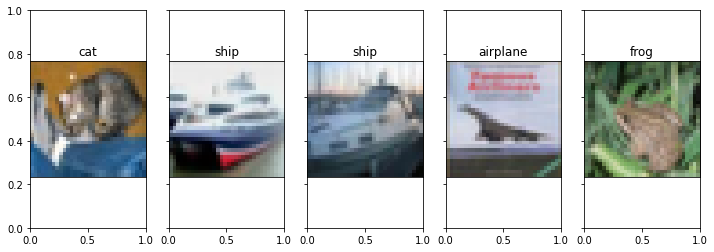

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


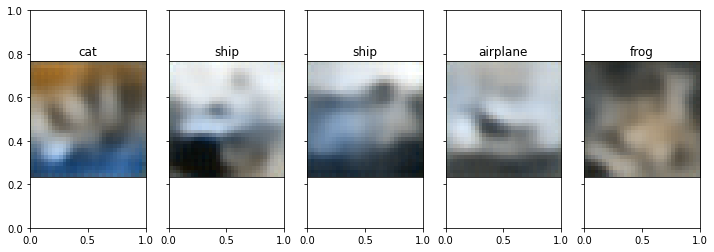

In [19]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

#Sample outputs
output = model(images.to(device))
images = images.permute(0, 2, 3, 1).numpy()
output = output.cpu().permute(0, 2, 3, 1).detach().numpy()
#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in range(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in range(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

# Latent space visualization

In [20]:
import itertools
latents = []
classes = [] 
with torch.no_grad():
    for images, cls_labels in itertools.islice(train_loader, 50):
        images = images.to(device)
        latents.extend(model.encode(images).cpu().numpy())
        classes.extend(cls_labels.numpy())

/home/emrecan/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/emrecan/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.000s...
[t-SNE] Computed neighbors for 6400 samples in 0.554s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 2.204152
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.156754
[t-SNE] KL divergence after 1000 iterations: 2.546719


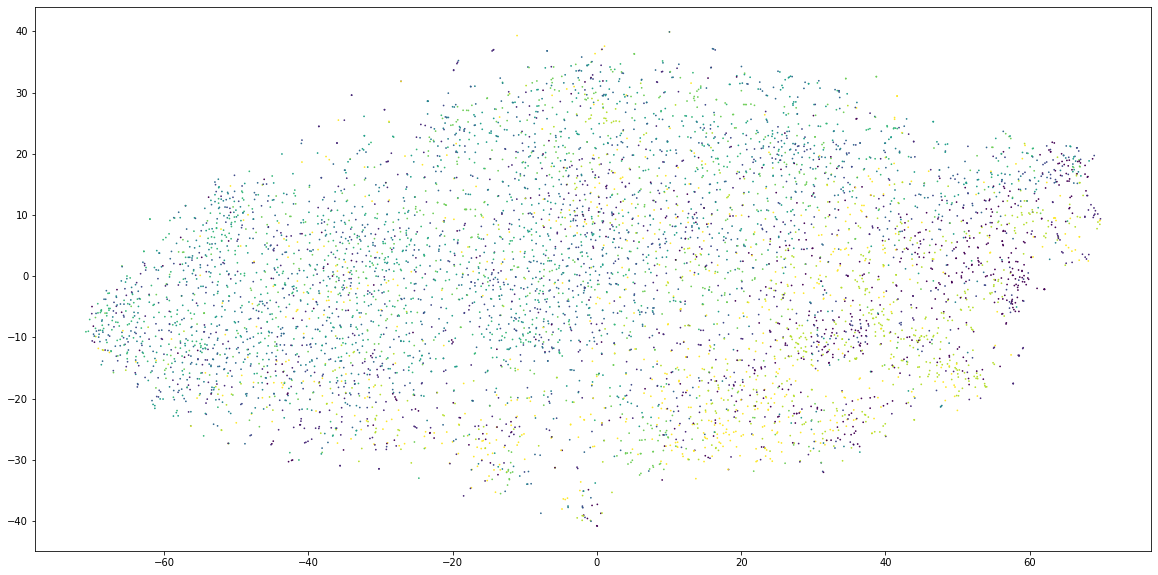

In [21]:
# visualize the embedding space
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
# project to 2d for visualization
embed = TSNE(n_components = 2, verbose=True)
Y = embed.fit_transform(latents)
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(Y[:,0], Y[:,1], c = classes, s = 0.5)